In [1]:
#!/usr/bin/env python3

import time

import pybullet as p
import pybullet_data

physicsClient = p.connect(p.DIRECT)  # p.DIRECT for non-graphical version

%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

class World(object):
    green = [0, 1, 0, 1]
    blue = [0, 0, 1, 1]
    red = [1, 0, 0, 1]

    def __init__(self):
        p.setAdditionalSearchPath(pybullet_data.getDataPath())  # used by loadURDF
        p.setGravity(0, 0, -10)
        p.loadURDF("plane.urdf")

        plane_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[1, 0.25, 1])
        plane_vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents=[1, 0.25, 1], rgbaColor=[1, 1, 0, 1])

        self.planeA = p.createMultiBody(baseCollisionShapeIndex=plane_id, basePosition=[0, 5, 2],
                                        baseVisualShapeIndex=plane_vis_id)
        self.planeB = p.createMultiBody(baseCollisionShapeIndex=plane_id, basePosition=[0, -5, 2],
                                        baseVisualShapeIndex=plane_vis_id)

        p.changeVisualShape(self.planeA, -1, rgbaColor=self.blue)
        p.changeVisualShape(self.planeB, -1, rgbaColor=self.blue)

        p.setRealTimeSimulation(0)

        self.targetVelocitySlider = p.addUserDebugParameter("wheelVelocity", -50, 20, 50)
        self.maxForceSlider = p.addUserDebugParameter("maxForce", 0, 150, 100)

    def loop(self, robot):
        count_step = 0
        last_robot_update_time = time.time()
        count_switch = 0
        last_switch_time = 0
        while 1:
            count_step = count_step + 1
            now = time.time()
            if now - last_switch_time > 5:
                last_switch_time = now
                count_switch = count_switch + 1
                if count_switch % 2 == 0:
                    p.changeVisualShape(self.planeA, -1, rgbaColor=self.green)
                    p.changeVisualShape(self.planeB, -1, rgbaColor=self.red)
                else:
                    p.changeVisualShape(self.planeA, -1, rgbaColor=self.red)
                    p.changeVisualShape(self.planeB, -1, rgbaColor=self.green)

            # render Camera at 10Hertz
            if now - last_robot_update_time > .1:
                # robot.maxForce = p.readUserDebugParameter(self.maxForceSlider)
                # robot.targetVelocity = p.readUserDebugParameter(self.targetVelocitySlider)
                robot.maxForce = 100
                robot.targetVelocity = 25
                robot.update()
                last_robot_update_time = now
            p.stepSimulation()
            time.sleep(0.0005)


class Brain(object):
    def __init__(self):
        self.min_red_ratio = 1000

    def process(self, count_red_left, count_red_right, count_non_red):
        if count_red_left + count_red_right < count_non_red / self.min_red_ratio:
            left_speed = -0.8
            right_speed = 0.8
        else:
            if count_red_left > count_red_right:
                left_speed = 0.6
                right_speed = 1
            else:
                left_speed = 1.0
                right_speed = 0.6

        return left_speed, right_speed


class Husky(object):
    maxForce = 0
    targetVelocity = 0

    def __init__(self, brain):
        self.brain = brain
        self.husky_model = p.loadURDF("husky/husky.urdf",
                                      basePosition=[0, 0, 1],
                                      baseOrientation=p.getQuaternionFromEuler([0, 0, 0]))

        # self.camInfo = p.getDebugVisualizerCamera()
        for joint in range(p.getNumJoints(self.husky_model)):
            # print("joint[", joint, "]=", p.getJointInfo(self.husky_model, joint))
            if p.getJointInfo(self.husky_model, joint)[1] == b'user_rail':
                self.zed_camera_joint = joint
            if p.getJointInfo(self.husky_model, joint)[1] == b'front_left_wheel':
                self.front_left_wheel = joint
            if p.getJointInfo(self.husky_model, joint)[1] == b'front_right_wheel':
                self.front_right_wheel = joint
            if p.getJointInfo(self.husky_model, joint)[1] == b'rear_left_wheel':
                self.rear_left_wheel = joint
            if p.getJointInfo(self.husky_model, joint)[1] == b'rear_right_wheel':
                self.rear_right_wheel = joint

    def update(self):
        img = self.update_cam()
        

        count_result = self.count_red_pixels(img)
        command_left, command_right = self.brain.process(*count_result)
        self.update_control(command_left, command_right)
        return img

    def update_control(self, command_left, command_right):
        p.setJointMotorControl2(self.husky_model, self.front_left_wheel, p.VELOCITY_CONTROL,
                                targetVelocity=command_left * self.targetVelocity,
                                force=self.maxForce)
        p.setJointMotorControl2(self.husky_model, self.rear_left_wheel, p.VELOCITY_CONTROL,
                                targetVelocity=command_left * self.targetVelocity,
                                force=self.maxForce)
        p.setJointMotorControl2(self.husky_model, self.front_right_wheel, p.VELOCITY_CONTROL,
                                targetVelocity=command_right * self.targetVelocity,
                                force=self.maxForce)
        p.setJointMotorControl2(self.husky_model, self.rear_right_wheel, p.VELOCITY_CONTROL,
                                targetVelocity=command_right * self.targetVelocity,
                                force=self.maxForce)

    def update_cam(self):
        ls = p.getLinkState(self.husky_model, self.zed_camera_joint, computeForwardKinematics=True)
        cam_pos = ls[0]
        cam_orn = ls[1]
        cam_mat = p.getMatrixFromQuaternion(cam_orn)
        forward_vec = [cam_mat[0], cam_mat[3], cam_mat[6]]
        cam_up_vec = [cam_mat[2], cam_mat[5], cam_mat[8]]
        cam_target = [cam_pos[0] + forward_vec[0] * 10,
                      cam_pos[1] + forward_vec[1] * 10,
                      cam_pos[2] + forward_vec[2] * 10]
        view_mat = p.computeViewMatrix(cam_pos, cam_target, cam_up_vec)
        # proj_mat = self.camInfo[3]
        
        pixelWidth = 320
        pixelHeight = 200
        nearPlane = 0.01
        farPlane = 100
        fov = 60
        aspect = pixelWidth / pixelHeight;
        proj_mat = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane);
        # getCameraImage seems to update the debug-view but I don't know why and how
        return p.getCameraImage(80, 80, viewMatrix=view_mat, projectionMatrix=proj_mat,
                                renderer=p.ER_BULLET_HARDWARE_OPENGL)

    @staticmethod
    def count_red_pixels(img):
        """detect left red and right red like nrp
        pixelformat is guessed, but it seems to work"""
        w = img[0]  # width of the image, in pixels
        h = img[1]  # height of the image, in pixels
        rgb_buffer = img[2]  # color data RGB
        # dep_buffer = img_arr[3]  # depth data
        count_red_right = 0
        count_red_left = 0
        count_non_red = 0
        for y in range(h):
            for x in range(w):
                r, g, b, a = (rgb_buffer[y][x][0], rgb_buffer[y][x][1],rgb_buffer[y][x][2],rgb_buffer[y][x][3])
                if r > g and r > b:
                    if x > w / 2:
                        count_red_right = count_red_right + 1
                    else:
                        count_red_left = count_red_left + 1
                else:
                    count_non_red = count_non_red + 1
        return count_red_left, count_red_right, count_non_red


my_word = World()
my_robot = Husky(brain=Brain())

# plt.ion()
robot = my_robot
robot.maxForce = 100
robot.targetVelocity = 50

<IPython.core.display.Javascript object>


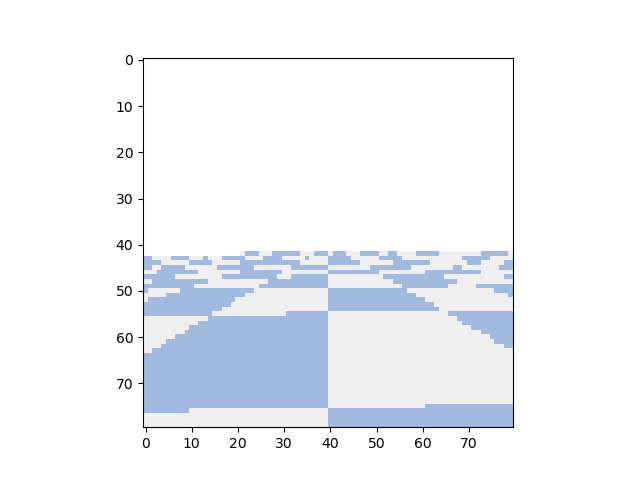

<IPython.core.display.Javascript object>


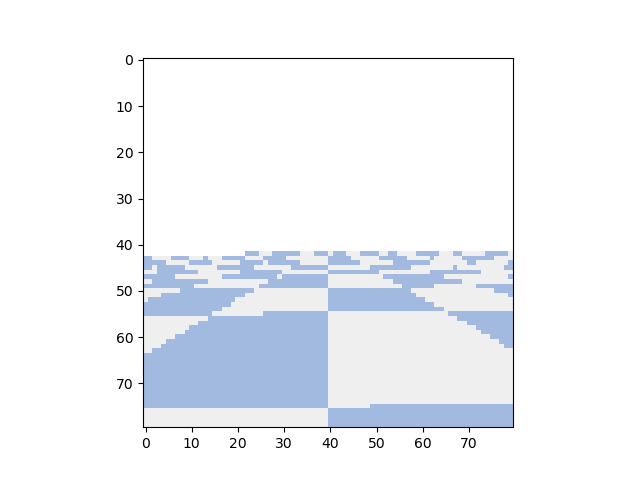

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

img = robot.update()
rgb=img[2] #color data RGB
myobj = plt.imshow(rgb,interpolation='none')

fig = plt.figure()
data = img[2]
# im = plt.imshow(data, cmap='gist_gray_r', vmin=0, vmax=1)
im = plt.imshow(data)

def init():
    im.set_data(data)

def animate(i):
    p.stepSimulation()
    img = robot.update()
    robot.update_control(1,-1)
    rgb=img[2] #color data RGB
    myobj.set_data(rgb)    
    im.set_data(rgb)
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=50,
                               interval=50)